# Introduction to the NormalFault component

This tutorial provides an introduction to the `NormalFault` component in the Landlab toolkit. This component takes the following parameters. 

    Parameters
    --------
    grid : ModelGrid
    faulted_surface : str or ndarray of shape `(n_nodes, )` or list of str
        or ndarrays. 
        Surface that is modified by the NormalFault component. Can be a
        field name or array or a list of strings or ndarrays if the fault.
        should uplift more than one field. Default value is 
        `topographic__elevation`.
    fault_throw_rate_through_time : dict, optional
        Dictionary that specifies the time varying throw rate on the fault.
        Expected format is:
        ``fault_throw_rate_through_time = {'time': array, 'rate': array}``
        Default value is a constant rate of 0.001 (units not specified).
    fault_dip_angle : float, optional
        Dip angle of the fault in degrees.  Default value is 90 degrees.
    fault_trace : dictionary, optional
        Dictionary that specifies the coordinates of two locations on the
        fault trace. Expected format is
        ``fault_trace = {'x1': float, 'y1': float, 'x2': float, 'y2': float}``
        where the vector from ``(x1, y1)`` to ``(x2, y2)`` defines the
        strike of the fault trace. The orientation of the fault dip relative
        to the strike follows the right hand rule.
        Default is for the fault to strike NE.
    include_boundaries : boolean, optional
        Flag to indicate if model grid boundaries should be uplifted. If
        set to ``True`` uplifted model grid boundaries will be set to the
        average value of their upstream nodes. Default value is False.


The `NormalFault` component will divide the model domain into two regions, a 'faulted nodes' region which will experience vertical rock uplift at a rate of 

$t \cdot \sin (d)$

where $t$ is the fault throw rate and $d$ is the fault dip angle. 

While dip angles less than 90 degrees are permitted, in its present implementation, the `NormalFault` component does not translate field information laterally. 

The fault orientation is specified by two coordinate pairs: (x1, y1) and (x2, y2). The strike of the fault, specified with the right-hand rule convention, is the vector from (x1, y1) to (x2, y2). Give that this component creates a normal fault, in which the footwall moves up relative to the hanging wall, this means that the nodes that are counterclockwise from the strike are the uplifted nodes. 

To start, let's import necessary Landlab and Python modules. 

In [1]:
# start by importing necessary modules 
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
from landlab import RasterModelGrid, HexModelGrid
from landlab.components import NormalFault, FastscapeEroder, FlowAccumulator, StreamPowerEroder
from landlab.plot import imshow_grid        

First we will make a default `NormalFault`.

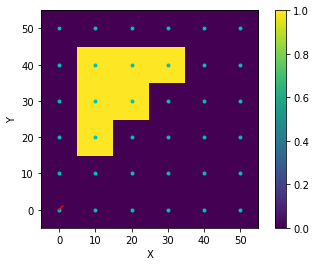

In [2]:
grid = RasterModelGrid((6, 6), xy_spacing=10)
    
_ = grid.add_zeros('node', 'topographic__elevation')

nf = NormalFault(grid) 

plt.figure()       
imshow_grid(grid, nf.faulted_nodes.astype(int), cmap='viridis')
plt.plot(grid.x_of_node, grid.y_of_node, 'c.')
plt.plot([nf.fault_trace['x1'], nf.fault_trace['x2']],
         [nf.fault_trace['y1'], nf.fault_trace['y2']], 'r')
plt.show()

 This fault has a strike of NE and dips to the SE. Thus the uplifted nodes (shown in yellow) are in the NW half of the domain.  

The default `NormalFault` will not uplift the boundary nodes. We change this by using the keyword argument `include_boundaries`. If this is specified, the elevation of the boundary nodes is calculated as an average of the faulted nodes adjacent to the boundaries. This occurs because most Landlab erosion components do not operate on boundary nodes. 

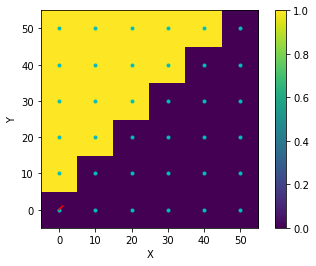

In [3]:
nf = NormalFault(grid, include_boundaries=True) 

plt.figure()       
imshow_grid(grid, nf.faulted_nodes.astype(int), cmap='viridis')
plt.plot(grid.x_of_node, grid.y_of_node, 'c.')
plt.plot([nf.fault_trace['x1'], nf.fault_trace['x2']],
         [nf.fault_trace['y1'], nf.fault_trace['y2']], 'r')
plt.show()

We can add functionality to the `NormalFault` with other keyword arguments. We can change the fault strike and dip, as well as specify a time series of fault uplift through time. 

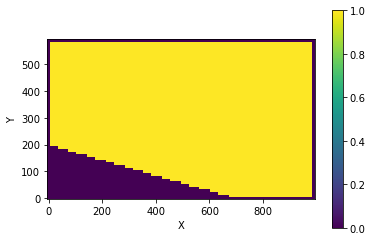

In [4]:
grid = RasterModelGrid((60, 100), xy_spacing=10)
z = grid.add_zeros('node', 'topographic__elevation')

nf = NormalFault(grid, fault_trace = {'x1': 0,
                                      'y1': 200, 
                                      'y2': 30, 
                                      'x2': 600})

imshow_grid(grid, nf.faulted_nodes.astype(int), cmap='viridis')       

By reversing the order of (x1, y1) and (x2, y2) we can reverse the location of the upthrown nodes (all else equal). 

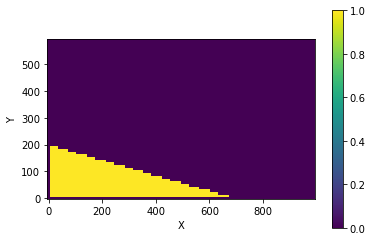

In [5]:
grid = RasterModelGrid((60, 100), xy_spacing=10)
z = grid.add_zeros('node', 'topographic__elevation')

nf = NormalFault(grid, fault_trace = {'y1': 30, 
                                      'x1': 600,
                                      'x2': 0,
                                      'y2': 200})

imshow_grid(grid, nf.faulted_nodes.astype(int), cmap='viridis')  

We can also specify complex time-rock uplift rate histories, but we'll explore that later in the tutorial. 

Next let's make a landscape evolution model with a normal fault. Here we'll use a HexModelGrid to highlight that we can use both raster and non-raster grids with this component. 

We will do a series of three numerical experiments and will want to keep a few parameters constant. Since you might want to change them, we are making it easier to change all of them together. They are defined in the next block:

In [6]:
# here are the parameters to change
K = 0.0005 # stream power coefficient, bigger = streams erode more quickly
U = 0.0001 # uplift rate in meters per year

dt = 1000 # time step in years
dx = 10 # space step in meters

nr = 60 # number of model rows
nc = 100 # number of model columns

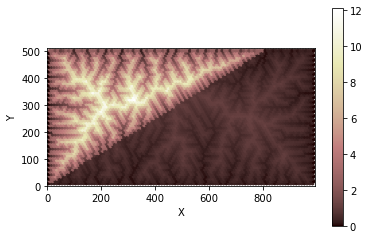

In [7]:
# instantiate the grid
grid = HexModelGrid(shape=(nr, nc), dx=dx, node_layout='rect')

# add a topographic__elevation field with noise
z = grid.add_zeros('node', 'topographic__elevation')
z[grid.core_nodes] += 100.0 + np.random.randn(grid.core_nodes.size)

fr = FlowAccumulator(grid)
fs = FastscapeEroder(grid, K_sp=K)
nf = NormalFault(grid, fault_trace={'x1': 0, 'x2': 800, 'y1': 0, 'y2': 500})

#Run this model for 300 100-year timesteps (30,000 years).        
for i in range(300):
    nf.run_one_step(dt)
    fr.run_one_step()
    fs.run_one_step(dt)
    z[grid.core_nodes] += 0.0001 * dt

# plot the final topography
imshow_grid(grid, z)       

As we can see, the upper left portion of the grid has been uplifted an a stream network has developed over the whole domain. 

How might this change when we also uplift the boundaries nodes?

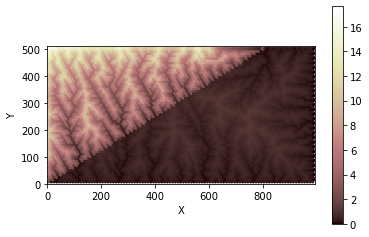

In [8]:
# instantiate the grid
grid = HexModelGrid(shape=(nr, nc), dx=10, node_layout='rect')

# add a topographic__elevation field with noise
z = grid.add_zeros('node', 'topographic__elevation')
z[grid.core_nodes] += 100.0 + np.random.randn(grid.core_nodes.size)

fr = FlowAccumulator(grid)
fs = FastscapeEroder(grid, K_sp=K)
nf = NormalFault(grid, fault_trace={'x1': 0, 'x2': 800, 'y1': 0, 'y2': 500}, include_boundaries=True)

#Run this model for 300 100-year timesteps (30,000 years). 
for i in range(300):
    nf.run_one_step(dt)
    fr.run_one_step()
    fs.run_one_step(dt)
    z[grid.core_nodes] += U * dt
    
# plot the final topography
imshow_grid(grid, z) 

We can see that when the boundary nodes are not included, the faulted region is impacted by the edge boundary conditions differently. Depending on your application, one or the other of these boundary condition options may suite your problem better. 

The last thing to explore is the use of the `fault_rate_through_time` parameter. This allows us to specify generic fault throw rate histories. For example, consider the following history, in which every 100,000 years there is a 10,000 year period in which the fault is active. 

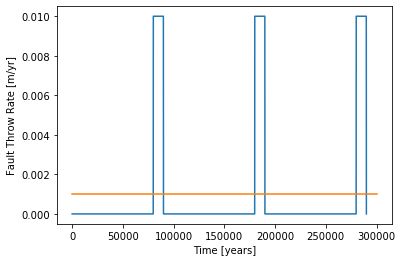

In [9]:
time = np.array([0.0, 7.99, 8.00, 8.99, 9.0, 17.99, 18.0, 18.99, 19.0, 27.99, 28.00, 28.99, 29.0]) * 10*dt
rate = np.array([0, 0, 0.01, 0.01, 0, 0, 0.01, 0.01, 0, 0, 0.01,0.01, 0])

plt.figure()
plt.plot(time, rate)
plt.plot([0, 300*dt], [0.001, 0.001])
plt.xlabel('Time [years]')
plt.ylabel('Fault Throw Rate [m/yr]')
plt.show()

The default value for uplift rate is 0.001 (units unspecified as it will depend on the x and t units in a model, but in this example we assume time units of years and length units of meters). 

This will result in a total of 300 m of fault throw over the 300,000 year model time period. This amount of uplift can also be accommodated by faster fault motion that occurs over shorter periods of time. 

Next we plot the cumulative fault throw for the two cases. 

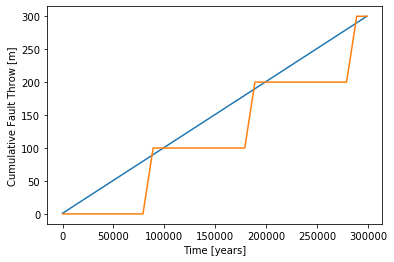

In [10]:
t = np.arange(0, 300*dt, dt)
rate_constant = np.interp(t, [0, 300*dt], [0.001, 0.001])
rate_variable = np.interp(t, time, rate)

cumulative_rock_uplift_constant = np.cumsum(rate_constant)*dt
cumulative_rock_uplift_variable = np.cumsum(rate_variable)*dt

plt.figure()
plt.plot(t, cumulative_rock_uplift_constant)
plt.plot(t, cumulative_rock_uplift_variable)
plt.xlabel('Time [years]')
plt.ylabel('Cumulative Fault Throw [m]')
plt.show()


A technical note: Beyond the times specified, the internal workings of the `NormalFault` will use the final value provided in the rate array. 

Let's see how this changes the model results. 

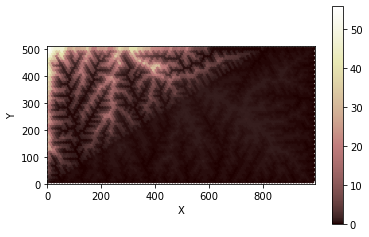

In [11]:
# instantiate the grid
grid = HexModelGrid(shape=(nr, nc), dx=10, node_layout='rect')

# add a topographic__elevation field with noise
z = grid.add_zeros('node', 'topographic__elevation')
z[grid.core_nodes] += 100.0 + np.random.randn(grid.core_nodes.size)

fr = FlowAccumulator(grid)
fs = FastscapeEroder(grid, K_sp=K)
nf = NormalFault(grid, fault_throw_rate_through_time={'time': time, 'rate': rate},
                 fault_trace={'x1': 0, 'x2': 800, 'y1': 0, 'y2': 500}, 
                 include_boundaries=True)

#Run this model for 300 100-year timesteps (30,000 years). 
for i in range(300):
    nf.run_one_step(dt)
    fr.run_one_step()
    fs.run_one_step(dt)
    z[grid.core_nodes] += U * dt
    
# plot the final topography
imshow_grid(grid, z) 

As you can see the resulting topography is very different than in the case with continuous uplift. 

For our final example, we'll use `NormalFault` with a more complicated model in which we have both a soil layer and bedrock. In order to move, material must convert from bedrock to soil by weathering.

First we import remaining modules and set some parameter values

In [12]:
from landlab.components import ExponentialWeatherer, ExponentialWeatherer, DepthDependentDiffuser

# here are the parameters to change
K = 0.0005 # stream power coefficient, bigger = streams erode more quickly
U = 0.0001 # uplift rate in meters per year
max_soil_production_rate  = 0.001 # Maximum weathering rate for bare bedrock in meters per year
soil_production_decay_depth = 0.7 # Characteristic weathering depth in meters
linear_diffusivity = 0.01 # Hillslope diffusivity and m2 per years
soil_transport_decay_depth = 0.5 # Characteristic soil transport depth in meters

dt = 100 # time step in years
dx = 10 # space step in meters

nr = 60 # number of model rows
nc = 100 # number of model columns


Next we create the grid and run the model. 

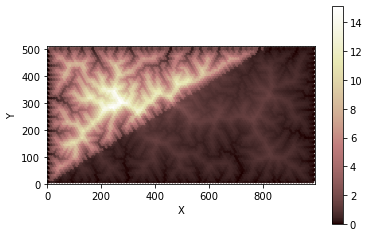

In [13]:
# instantiate the grid
grid = HexModelGrid(shape=(nr, nc), dx=10, node_layout='rect')

# add a topographic__elevation field with noise
z = grid.add_zeros('node', 'topographic__elevation')
z[grid.core_nodes] += 100.0 + np.random.randn(grid.core_nodes.size)

# create a field for soil depth
d = grid.add_zeros('node', 'soil__depth')

# create a bedrock elevation field
b = grid.add_zeros('node', 'bedrock__elevation')
b[:] = z - d


fr = FlowAccumulator(grid, depression_finder='DepressionFinderAndRouter', routing='D4')
fs = FastscapeEroder(grid, K_sp=K)
ew = ExponentialWeatherer(grid, 
                          soil_production_decay_depth=soil_production_decay_depth, 
                          max_soil_production_rate=max_soil_production_rate)

dd = DepthDependentDiffuser(grid, 
                            linear_diffusivity=linear_diffusivity, 
                            soil_transport_decay_depth=soil_transport_decay_depth)

nf = NormalFault(grid, 
                 fault_throw_rate_through_time={'time': [0, 30], 'rate': [0.001, 0.001]},
                 fault_trace={'x1': 0, 'x2': 800, 'y1': 0, 'y2': 500}, 
                 include_boundaries=False)

#Run this model for 300 100-year timesteps (30,000 years). 
for i in range(300):
    
    # Move normal fault
    nf.run_one_step(dt)

    # Route flow
    fr.run_one_step()

    # Erode with water
    fs.run_one_step(dt)

    # We must also now erode the bedrock where relevant. If water erosion
    # into bedrock has occurred, the bedrock elevation will be higher than
    # the actual elevation, so we simply re-set bedrock elevation to the
    # lower of itself or the current elevation.
    b = grid.at_node['bedrock__elevation']
    b[:] = np.minimum(b, grid.at_node['topographic__elevation'])

    # Calculate regolith-production rate
    ew.calc_soil_prod_rate()

    # Generate and move soil around. This component will update both the
    # soil thickness and topographic elevation fields. 
    dd.run_one_step(dt)

    # uplift the whole domain, we need to do this to both bedrock and topography
    z[grid.core_nodes] += U * dt
    b[grid.core_nodes] += U * dt
    

# plot the final topography
imshow_grid(grid, 'topographic__elevation') 

We can also examine the soil thickness and soil production rate. Here in the soil depth, we see it is highest along the ridge crests.  

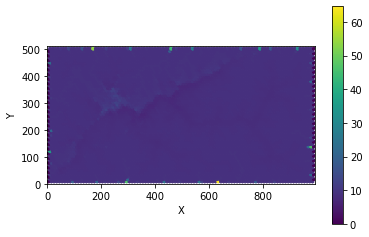

In [14]:
# and the soil depth
imshow_grid(grid, 'soil__depth', cmap='viridis') 

The soil production rate is highest where the soil depth is low, as we would expect given the exponential form. 

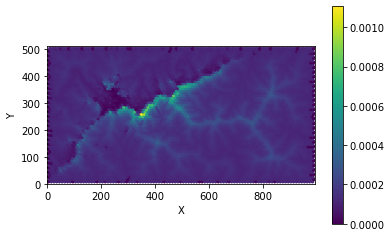

In [15]:
# and the soil production rate
imshow_grid(grid, 'soil_production__rate', cmap='viridis') 